# CV Utils - Object Detection example

###### Fashion dataset (Kaggle)  https://www.kaggle.com/datafiniti/womens-shoes-prices

### 0 - Setup

###### Import pckgs

In [4]:
from cv_utils import *
import warnings
warnings.filterwarnings("ignore")

###### Import data

In [2]:
# Reading the csv with price and image url
import csv

with open('data/data.csv', 'r') as file:
    table = csv.reader(file, delimiter=',')
    
    ## skip headers
    next(table, None)
    
    ## some items are the same, I'll keep the unique values (653 rows)
    lst_id, data = [], []
    for row in table:
        if row[0] not in lst_id:
            lst_id.append(row[0])
            price = float(row[16])
            price_class = "0_50" if (price <= 50) else ("over100" if (price > 100) else "50_100")
            data.append({"url":row[10], "price":price, "price_class":price_class})
        else:
            next
    
    ## insert a custom id
    for i,dic in enumerate(data):
        dic["id"]=i
        
print("len:", len(data))
data[0]

len: 653


{'url': 'https://i5.walmartimages.com/asr/861ca6cf-fa55-4a48-904d-b764d7c00f0c_1.1a2bb39923e1486d05bdafe37ad832e3.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/efe9ba1e-daed-4534-9e2e-11804bbb30f1_1.62e3e7f0268f641323a245d5caebdd6d.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/0c717815-228e-4c9b-a8fc-d033576461c9_1.f08402e0a5165746e133ddeb589c73e0.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/f46703c8-2cdb-4bf2-a3ea-819f24aab134_1.df725b76ca0112d64bdf566ad97760a9.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/f652f354-a1fb-47ac-b507-7f97eb216b14_1.39e78b87e2328421803115869ee8b950.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,http://ak1.ostkcdn.com/images/products/84/146/P16141204.jpg,http://s1.shoes.com/images/br021/womens-naturalizer-danya-soft-silver-crosshatch-shiny-377672_366_tp.jpg,http://s3.shoes.com/images/br021/womens-naturalizer-danya-soft-silver-crossh

In [21]:
# Create the file system structure
import os

lst_folders = ["raw_images", "pretrained_models",
               "training_yolo/train/images", "training_yolo/train/annotations",
               "training_yolo/validation/images", "training_yolo/validation/annotations",
               "training_cnn/train/0_50", "training_cnn/train/50_100", "training_cnn/train/over100",
               "training_cnn/validation/0_50", "training_cnn/validation/50_100", "training_cnn/validation/over100"
               ]
for folder in lst_folders:
    if not os.path.exists("fs/"+folder):
        os.makedirs("fs/"+folder)

## print folder structure
for root, dirs, files in os.walk("fs"):
    path = root.split(os.sep)
    print((len(path) - 1) * ' /', os.path.basename(root))
    for file in files:
        print(len(path) * '  ', file)

In [ ]:
# Scraping the imgaes from the web and downloading on file system
import requests

for dic in data:
    try:
        res = requests.get(dic["url"])
        if res.status_code == 200:
            file_name = str(dic["id"])+'.jpg'
            file = open("fs/raw_images/"+file_name,'wb')
            file.write(res.content)
            file.close()
            
    except Exception as e:
        print("failed on:", dic["id"], "| res:", res.status_code, " | error:", e)
        next

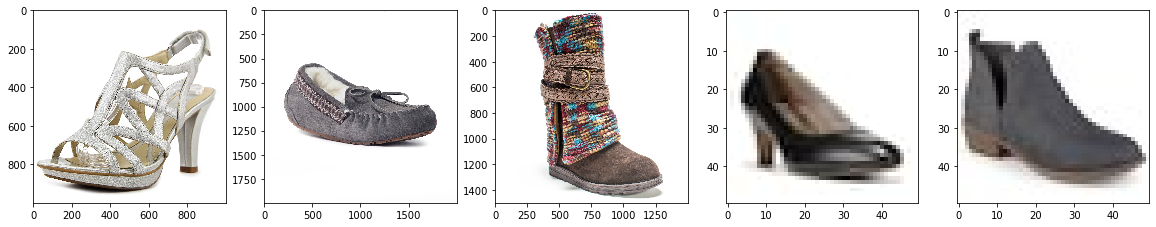

shape: (1000, 1000, 3)


In [5]:
# Load all images
lst_imgs = load_imgs(dirpath="fs/raw_images/", plot=True, ext=['.png','.jpg','.jpeg','.JPG'])
print("shape:", lst_imgs[0].shape)

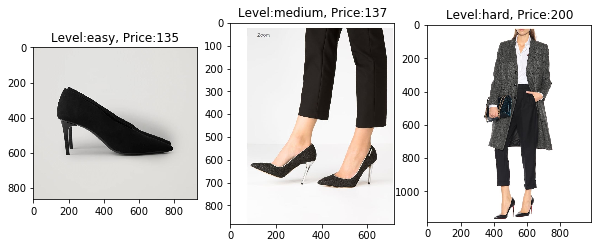

In [6]:
# Load Validation images
lst_new_imgs = load_imgs(dirpath="data/")
plot_imgs(lst_new_imgs, lst_titles=["Level:easy, Price:135", "Level:medium, Price:137", "Level:hard, Price:200"], figsize=(10,5))

### 1 - Image Analysis

###### Target Variable

len: 653
mean: 59.81194486983154


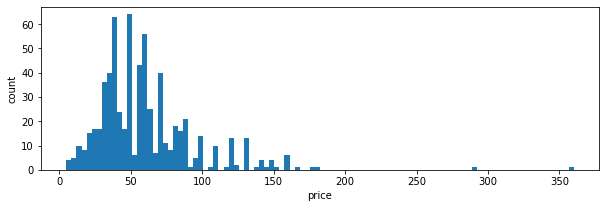

In [7]:
y = [dic["price"] for dic in data]

print("len:", len(y))
print("mean:", np.mean(y))

fig, ax = plt.subplots(figsize=(10,3))
ax.hist(y, bins=100)
ax.set(xlabel='price', ylabel="count")
plt.show()

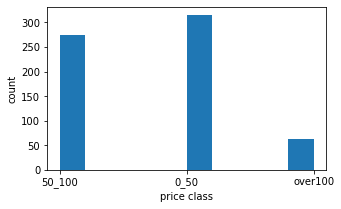

In [8]:
y = [dic["price_class"] for dic in data]

fig, ax = plt.subplots(figsize=(5,3))
ax.hist(y)
ax.set(xlabel='price class', ylabel="count")
plt.show()

###### Size

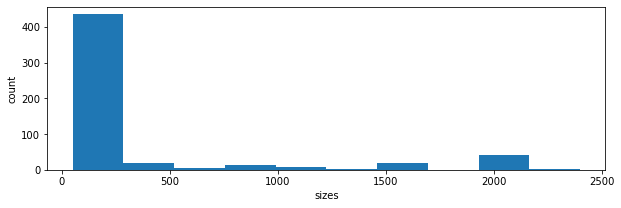

In [9]:
sizes = [i.shape[0] for i in lst_imgs]

fig, ax = plt.subplots(figsize=(10,3))
ax.hist(sizes, bins=10)
ax.set(xlabel='sizes', ylabel="count")
plt.show()

###### Colors

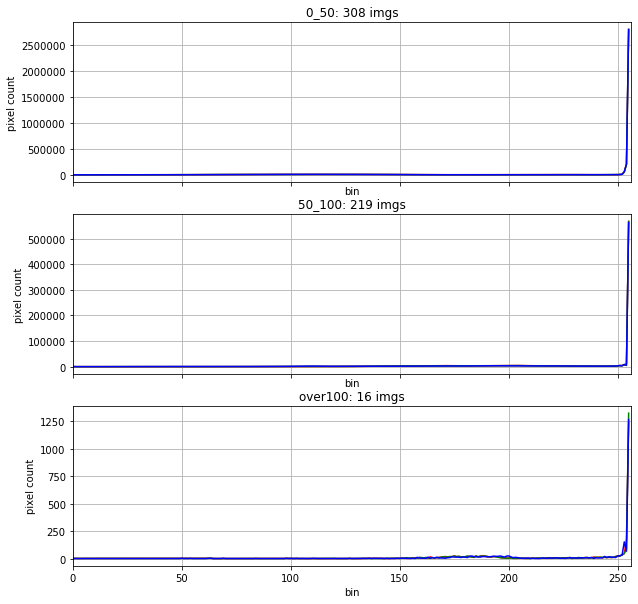

In [10]:
utils_color_distributions(lst_imgs, y, figsize=(10,10))

### 2 - Preprocessing for Detection

###### Features Engineering

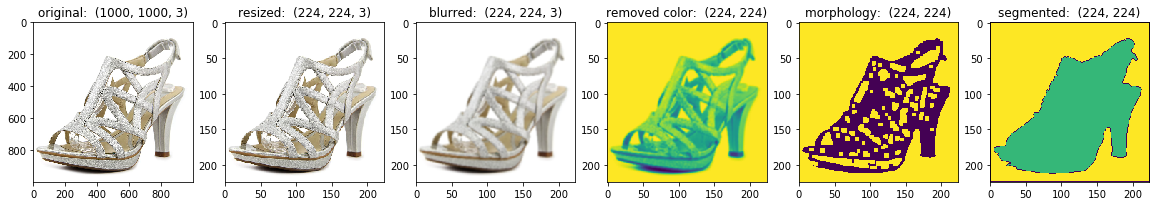

In [11]:
ex = utils_preprocess_img(lst_imgs[0], resize=224, denoise=True, remove_color=True, morphology=True, segmentation=True, plot=True)

In [ ]:
#lst_imgs = [utils_preprocess_img(img, resize=224, denoise=True, remove_color=True, morphology=True) for img in lst_imgs]

In [ ]:
# No preprocessing needed

###### Partitioning

In [13]:
split = int(len(lst_imgs)*0.90)

# Train
print("Train: ", split, "images")
save_imgs(lst_imgs=lst_imgs[:split], dirpath="fs/training_yolo/train/images/", i=0)

# Test
print("Test: ", len(lst_imgs)-split, "images")
save_imgs(lst_imgs=lst_imgs[split:], dirpath="fs/training_yolo/validation/images/", i=split)

###### Create Annotations

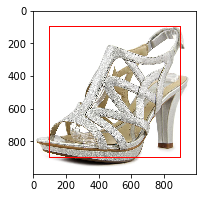

In [14]:
# Check what rectangle measures shall be appropriate
img = lst_imgs[0]
xmin = int(img.shape[0]*0.10)
ymin = int(img.shape[1]*0.10)
xmax = int(img.shape[0]*0.90)
ymax = int(img.shape[1]*0.90)
utils_plot_img(img, mask=None, rect=[(xmin,ymin), (xmax,ymax)], figsize=(5,3))

In [15]:
# Creating xml annotation file for each image
import xml.etree.cElementTree as XML

def create_annotations(lst_imgs, dirpath_annot, dirpath_img, i=0):
    for img in lst_imgs:
        try:
            img_name, xml_name = str(i)+".jpg", str(i)+".xml"

            ## xml structure
            annotation = XML.Element("annotation")
            XML.SubElement(annotation, "folder").text = "images"
            XML.SubElement(annotation, "filename").text = img_name
            XML.SubElement(annotation, "path").text = dirpath_img+img_name

            source = XML.SubElement(annotation, "source")
            XML.SubElement(source, "database").text = "Unknown"

            size = XML.SubElement(annotation, "size")
            XML.SubElement(size, "width").text = str(img.shape[0])
            XML.SubElement(size, "height").text = str(img.shape[1])
            XML.SubElement(size, "depth").text = str(img.shape[2])

            XML.SubElement(annotation, "segmented").text = "0"

            object = XML.SubElement(annotation, "object")
            XML.SubElement(object, "name").text = "shoes"
            XML.SubElement(object, "pose").text = "Unspecified"
            XML.SubElement(object, "truncated").text = "0"
            XML.SubElement(object, "difficult").text = "0"
            bndbox = XML.SubElement(object, "bndbox")
            XML.SubElement(bndbox, "xmin").text = str(int(img.shape[0]*0.10))
            XML.SubElement(bndbox, "ymin").text = str(int(img.shape[1]*0.10))
            XML.SubElement(bndbox, "xmax").text = str(int(img.shape[0]*0.90))
            XML.SubElement(bndbox, "ymax").text = str(int(img.shape[1]*0.90))

            ## write xml
            xml_file = XML.ElementTree(annotation)
            xml_file.write(dirpath_annot+xml_name)
            i += 1

        except Exception as e:
            print("failed on:", i, "| error:", e)
            i += 1
            pass

In [16]:
# Train
create_annotations(lst_imgs[:split], dirpath_annot="fs/training_yolo/train/annotations/", 
                                     dirpath_img="fs/training_yolo/train/images/", i=0)
# Test
create_annotations(lst_imgs[split:], dirpath_annot="fs/training_yolo/validation/annotations/", 
                                     dirpath_img="fs/training_yolo/validation/images/", i=split)

failed on: 90 | error: tuple index out of range


In [17]:
file = XML.parse("fs/training_yolo/train/annotations/0.xml")
root = file.getroot()
print(root.tag)
for elem in root:
    print(" ", elem.tag, ":", elem.text)
    if len(elem.getchildren()) > 0:
        for subelem in elem:
            print("   - ", subelem.tag, ":", subelem.text)
            if len(subelem.getchildren()) > 0:
                for subsubelem in subelem:
                    print("     - ", subsubelem.tag, ":", subsubelem.text)

annotation
  folder : images
  filename : 0.jpg
  path : fs/training_yolo/train/images/0.jpg
  source : None
   -  database : Unknown
  size : None
   -  width : 1000
   -  height : 1000
   -  depth : 3
  segmented : 0
  object : None
   -  name : shoes
   -  pose : Unspecified
   -  truncated : 0
   -  difficult : 0
   -  bndbox : None
     -  xmin : 100
     -  ymin : 100
     -  xmax : 900
     -  ymax : 900


### 3 - Model Desing & Testing (YOLO for detection)

###### Train

In [ ]:
# this takes 10 hours
yolo = train_yolo(lst_y=["shoes"], train_path="fs/training_yolo/", transfer_modelfile="fs/pretrained_models/yolo_base.h5")

###### Evaluate

In [18]:
#yolo = load_yolo(modelfile="fs/pretrained_models/yolo_shoes_nopreprocess.h5", 
#                 confjson="fs/pretrained_models/detection_config.json")

Instructions for updating:
Colocations handled automatically by placer.


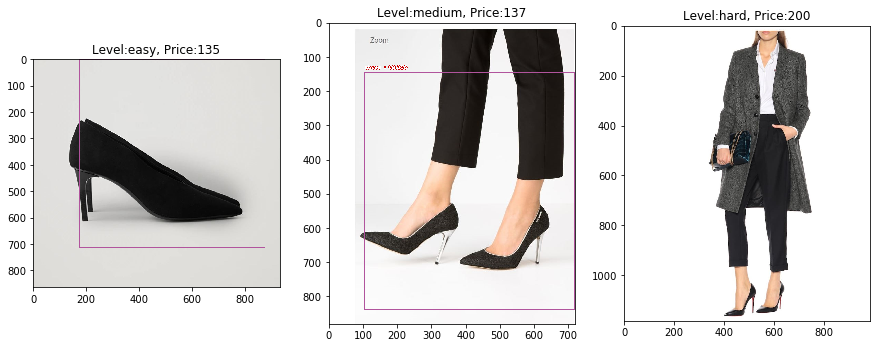

In [19]:
yolo_predicted = [obj_detect_yolo(new_img, yolo, min_prob=60)[0] for new_img in lst_new_imgs]
plot_imgs(yolo_predicted, lst_titles=["Level:easy, Price:135", "Level:medium, Price:137", "Level:hard, Price:200"], figsize=(15,10))

### 4 - Preprocessing for Classification

###### Partitioning

### 5 - Model Desing & Testing (CNN for classification)

###### Features Engineering

In [ ]:
img_processed = utils_preprocess_img(lst_imgs[0], plot=True, figsize=(20,13), resize=224, denoise=True, 
                                     remove_color=True, morphology=True, segmentation=True)

In [ ]:
lst_new_imgs_processed = [utils_preprocess_img(new_img, plot=False, resize=224) for new_img in lst_new_imgs]
plot_multi_imgs(lst_new_imgs_processed, lst_titles=["Level:easy, Price:135", "Level:medium, Price:137", "Level:hard, Price:200"], figsize=(15,10))

###### Train

###### Evaluate